In [90]:
# Load the Datasets
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [91]:
default_batch_size = 64
torch.manual_seed(0) # Used to create reproducible outputs

In [92]:
# Load MNIST
# MNIST transform to preprocess the data
transform_mnist = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=default_batch_size, shuffle=False)

In [93]:
# VAE Model Definition
class VAE_linear(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.2):
        super(VAE_linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, latent_size * 2, device=default_device))  # x2 for mean and variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, input_size, device=default_device),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=default_device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoding = self.encoder(x)
        mu, log_var = torch.chunk(encoding, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var
    
def vae_loss_function(recon_x, x, mu, log_var, input_size):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE, KLD)

In [94]:
# Hyperparameters
input_size = 28 * 28 # Size of MNIST images - 784
hidden_size = 512 # Hidden size for hidden layer
latent_size = 32 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 25 # Number of epochs to train for

# Initialize the model
vae_model_mnist = VAE_linear(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_mnist.parameters(), lr=learning_rate)

In [95]:
BCE_loss = []
KLD_loss = []
total_loss = []

# VAE Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader_mnist, 0):
        inputs, _ = data
        inputs = inputs.view(-1, input_size).to(default_device)
        inputs = Variable(inputs)

        # PyTorch accumulates gradients on subsequent backward passes - so zero the grads
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = vae_model_mnist(inputs)

        # Binary cross entropy, KL divergence
        (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
        totalloss = BCE + 2*KLD

        # Backward pass
        totalloss.backward()

        # Update weights
        optimizer.step()

        BCE_loss.append(BCE.item()/input_size)
        KLD_loss.append(KLD.item()/input_size)
        total_loss.append(totalloss.item()/input_size)

        if i % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, len(trainloader_mnist), BCE.item()/input_size, KLD.item()/input_size, totalloss.item()/input_size))

Epoch [1/25], Step [1/938], BCE: 44.5178, KLD: 0.0056, Total Loss: 44.5289
Epoch [2/25], Step [1/938], BCE: 11.3360, KLD: 0.6537, Total Loss: 12.6434
Epoch [3/25], Step [1/938], BCE: 10.7736, KLD: 0.7136, Total Loss: 12.2008
Epoch [4/25], Step [1/938], BCE: 10.3149, KLD: 0.7236, Total Loss: 11.7622
Epoch [5/25], Step [1/938], BCE: 10.0085, KLD: 0.7335, Total Loss: 11.4755
Epoch [6/25], Step [1/938], BCE: 9.5795, KLD: 0.7634, Total Loss: 11.1062
Epoch [7/25], Step [1/938], BCE: 9.7038, KLD: 0.7523, Total Loss: 11.2084
Epoch [8/25], Step [1/938], BCE: 10.1751, KLD: 0.8095, Total Loss: 11.7940
Epoch [9/25], Step [1/938], BCE: 10.3823, KLD: 0.7688, Total Loss: 11.9198
Epoch [10/25], Step [1/938], BCE: 9.3549, KLD: 0.7462, Total Loss: 10.8474
Epoch [11/25], Step [1/938], BCE: 9.9583, KLD: 0.8131, Total Loss: 11.5844
Epoch [12/25], Step [1/938], BCE: 10.1422, KLD: 0.8059, Total Loss: 11.7540
Epoch [13/25], Step [1/938], BCE: 10.2794, KLD: 0.8130, Total Loss: 11.9055
Epoch [14/25], Step [1/93

## Plot the Results

Text(0, 0.5, 'Loss')

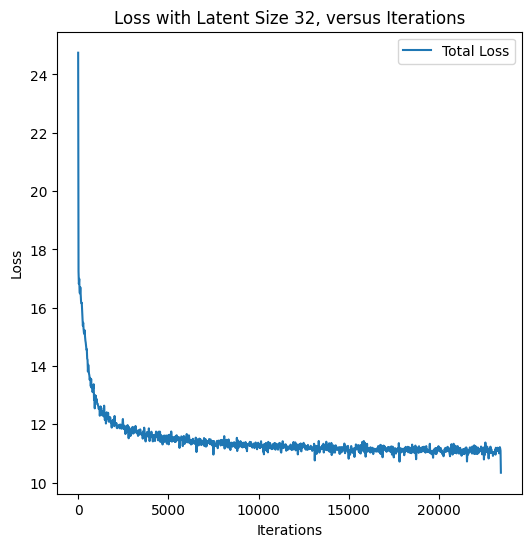

In [96]:
# Plot the losses
number_bins = 20
# Bin the discriminator losses and calculate the averages
binned_BCE_loss = [np.mean(BCE_loss[i:i + number_bins]) for i in range(0, len(BCE_loss), number_bins)]
binned_KLD_loss = [np.mean(KLD_loss[i:i + number_bins]) for i in range(0, len(KLD_loss), number_bins)]
binned_total_loss = [np.mean(total_loss[i:i + number_bins]) for i in range(0, len(total_loss), number_bins)]

plt.figure(figsize=(6, 6))
# plt.subplot(1, 3, 1)
# plt.plot(range(0, len(BCE_loss), number_bins), binned_BCE_loss, label='BCE Loss')

# plt.legend()
# plt.title('Binary Cross Entropy Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

plt.plot(range(0, len(total_loss), number_bins), binned_total_loss, label='Total Loss')
plt.legend()
plt.title(f'Loss with Latent Size {latent_size}, versus Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# plt.subplot(1, 3, 3)
# plt.plot(range(0, len(KLD_loss), number_bins), binned_KLD_loss, label='KLD Loss')
# plt.legend()
# plt.title('KL Divergence')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

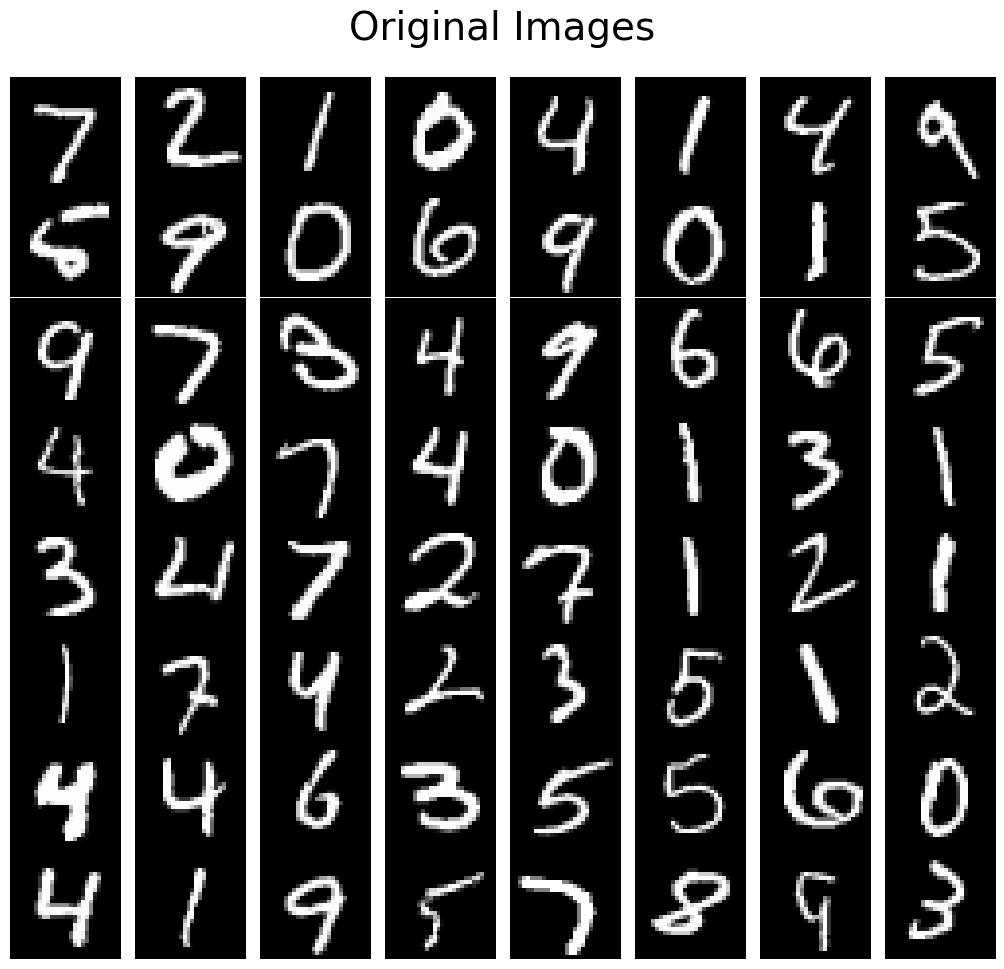

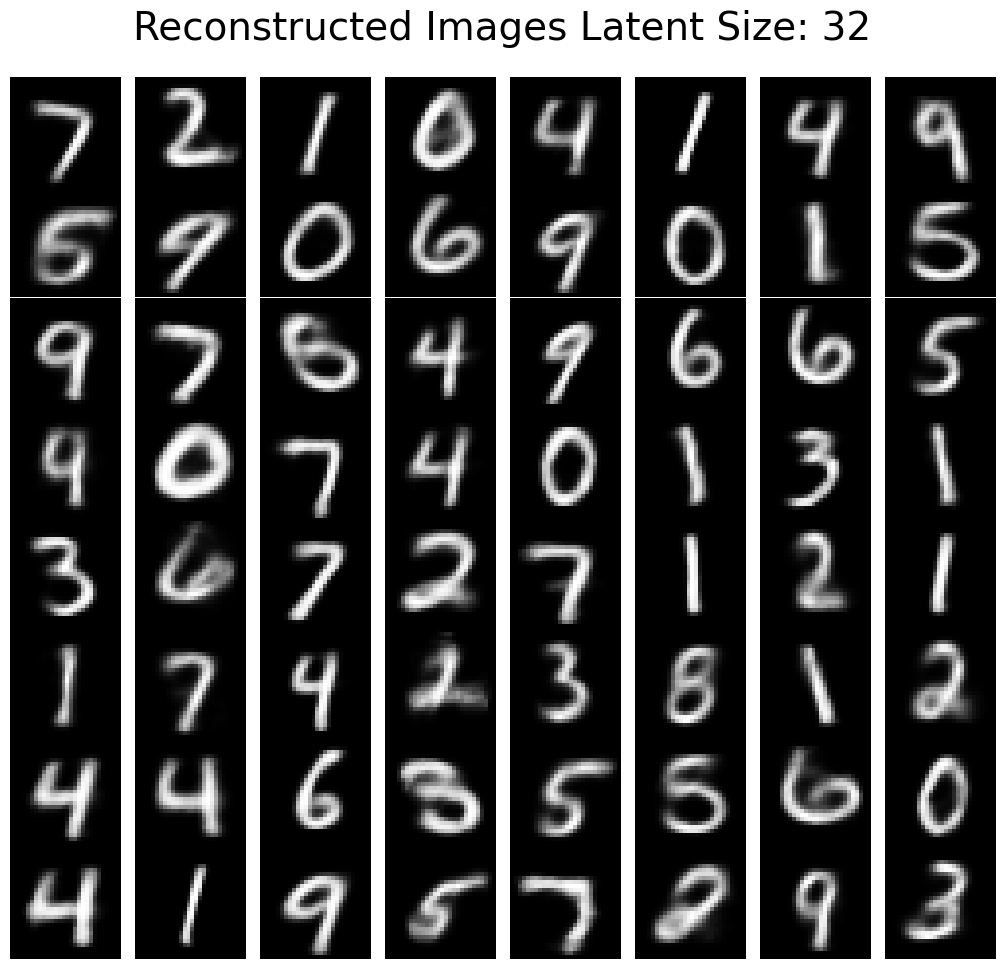

In [97]:
# Display the images in a grid
import matplotlib.pyplot as plt

n_samples = 64  # Adjust the number of samples you want to visualize
num_rows = 8
num_cols = n_samples // num_rows

# Initialize lists to store original and reconstructed images for testing
test_original_images = []
test_reconstructed_images = []

# Evaluate on the entire testing dataset
with torch.no_grad():
    for data in testloader_mnist:
        inputs, _ = data
        inputs = inputs.view(-1, input_size).to(default_device)
        
        # Forward pass
        recon_batch, _, _ = vae_model_mnist(inputs)

        # Convert to numpy arrays for visualization
        test_original_images.append(inputs.cpu().numpy())
        test_reconstructed_images.append(recon_batch.cpu().numpy())

# Concatenate the batches
test_original_images = np.concatenate(test_original_images, axis=0)
test_reconstructed_images = np.concatenate(test_reconstructed_images, axis=0)

# Resize the images to 28 x 28
orig_images_to_show = [img.reshape(28, 28) for img in test_original_images[:n_samples]]
recon_images_to_show = [img.reshape(28, 28) for img in test_reconstructed_images[:n_samples]]


# Plot the original images
# Plot original images in an 8x8 grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
fig.suptitle('Original Images', fontsize=28)
for i in range(num_rows):
    for j in range(num_cols):
        axes[i, j].imshow(orig_images_to_show[i * num_cols + j], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout(pad=0, rect=[0, 0.03, 1, 0.95]) 
# plt.subplots_adjust(wspace=0.001, hspace=0.001)  # Set spacing to 0.1
plt.show()

# Plot reconstructed images in an 8x8 grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
fig.suptitle(f'Reconstructed Images Latent Size: {latent_size}', fontsize=28)
for i in range(num_rows):
    for j in range(num_cols):
        axes[i, j].imshow(recon_images_to_show[i * num_cols + j], cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout(pad=0, rect=[0, 0.03, 1, 0.95]) 
plt.show()
